In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

import tqdm

%matplotlib inline

## Carga de Datos

images_train: (240000, 784)
labels_train: (240000, 10)
images_test: (40000, 784)
labels_test: (40000, 10)
Algunas imagenes de entrenamiento.


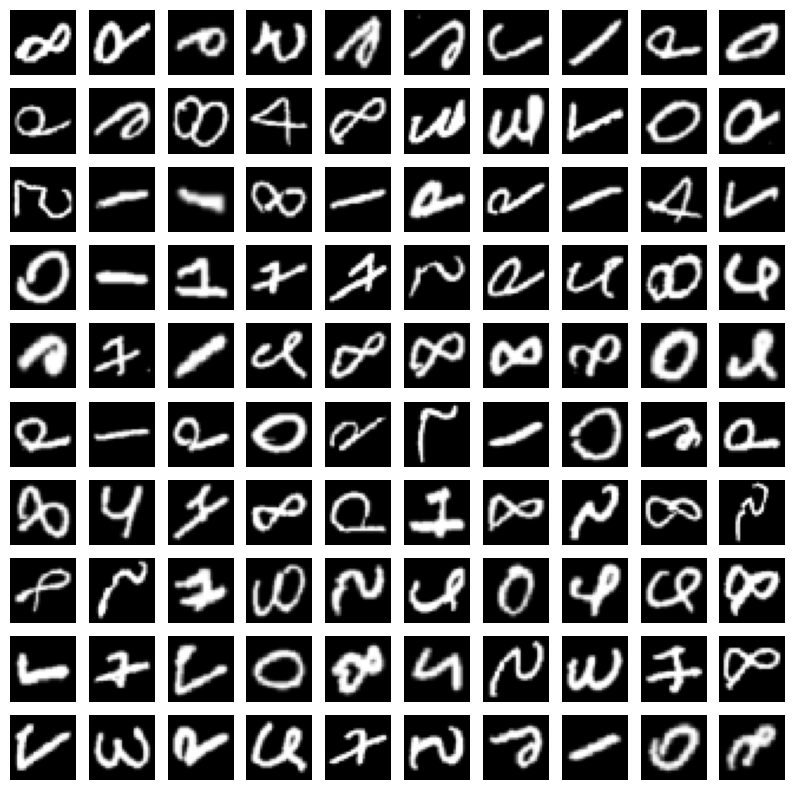

In [71]:
# read datasets from csv files
train = pd.read_csv("./data/emnist-digits-train.csv", header=None).to_numpy()
test = pd.read_csv("./data/emnist-digits-test.csv", header=None).to_numpy()

# separate first column from the rest as it contains the labels
images_train = train[:, 1:]
labels_train = train[:, 0]
images_test = test[:, 1:]
labels_test = test[:, 0]

# normalize the images
images_train = images_train / 255
images_test = images_test / 255

# one-hot encode the labels
labels_train = np.eye(10)[labels_train]
labels_test = np.eye(10)[labels_test]

# print the shape of the variables
for i in ["images_train", "labels_train", "images_test", "labels_test"]:
    print(f"{i}: {eval(i).shape}")

print("Algunas imagenes de entrenamiento.")
# plot some training images
fig, ax = plt.subplots(10, 10, figsize=(10, 10))
for i in range(10):
    for j in range(10):
        ax[i, j].imshow(images_train[i * 10 + j].reshape(28, 28), cmap="gray")
        ax[i, j].axis("off")
plt.show()


## Procesamiento de Datos

### Rotación y Reflejo

images_train: (240000, 28, 28)
labels_train: (240000, 10)
images_test: (40000, 28, 28)
labels_test: (40000, 10)
Imagenes de entrenamiento despues de rotar y reflejar.


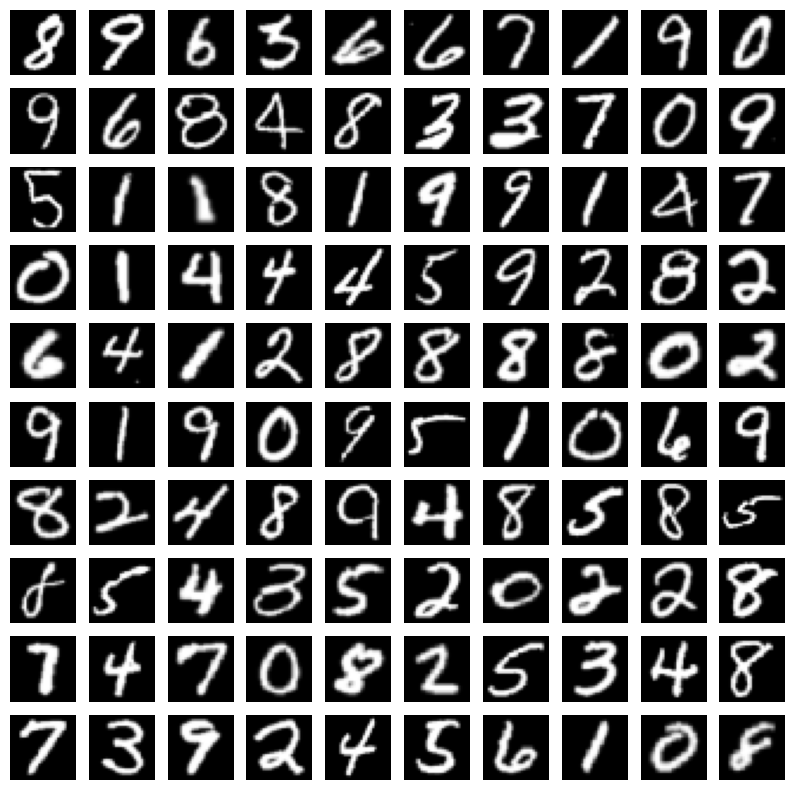

In [72]:
# images are flipped, rotated and in 1D, so we need to fix them
# define a function to fix the images
def reshape_flip_and_rotate(image):
    image = image.reshape(28, 28)
    image = np.fliplr(image)
    image = np.rot90(image)
    return image


# fix the images
images_train = np.apply_along_axis(reshape_flip_and_rotate, 1, images_train)
images_test = np.apply_along_axis(reshape_flip_and_rotate, 1, images_test)

# print the shape of the variables
for i in ["images_train", "labels_train", "images_test", "labels_test"]:
    print(f"{i}: {eval(i).shape}")

print("Imagenes de entrenamiento despues de rotar y reflejar.")
# plot some training images
fig, ax = plt.subplots(10, 10, figsize=(10, 10))
for i in range(10):
    for j in range(10):
        ax[i, j].imshow(images_train[i * 10 + j], cmap="gray")
        ax[i, j].axis("off")
plt.show()


### Enderezamiento

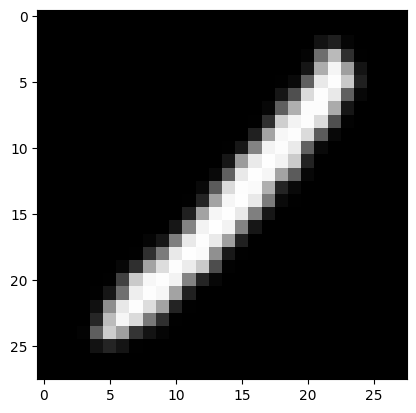

In [73]:
sample_index = 7
sample_image = images_train[sample_index]
sample_label = labels_train[sample_index]

plt.imshow(sample_image, cmap="gray")


Los momentos de una imagen describen la forma de la distribución en cada eje.
- 1er momento - Media (describe el valor central)
- 2do momento - Varianza (describe la dispersión)
- 3er momento - Asimetría (describe la asimetría)
- 4to momento - Curtosis (describe picos)

Para enderezar la imagen, se le aplica una transformación afín con la inversa de su asimetría.
Para calcular su asimetría, se utiliza la asimetría en el eje x (`mu02`) en relación con la varianza en ambos ejes (`mu11`).

In [74]:
# calculate the moments of the image
sample_m = cv2.moments(sample_image)
sample_m


{'m00': 83.9607843137255,
 'm10': 1203.8901960784312,
 'm01': 1173.8117647058825,
 'm20': 19503.937254901954,
 'm11': 14383.607843137255,
 'm02': 19301.623529411765,
 'm30': 342536.6666666668,
 'm21': 203295.46666666662,
 'm12': 208372.30588235293,
 'm03': 349508.5411764706,
 'mu20': 2241.692552682911,
 'mu11': -2447.350646848183,
 'mu02': 2891.175839767009,
 'mu30': -1410.837584772904,
 'mu21': 804.8843473145098,
 'mu12': 41.98220606188988,
 'mu03': -1177.3825737428851,
 'nu20': 0.3179970384008797,
 'nu11': -0.34717082710328445,
 'nu02': 0.41012999460686206,
 'nu30': -0.02184166811119912,
 'nu21': 0.012460694959988907,
 'nu12': 0.0006499411564282715,
 'nu03': -0.018227469762042744}

In [75]:
sample_m["mu11"] / sample_m["mu02"]


-0.8464897268391006

Algunas imagenes de entrenamiento antes y despues de endezar.


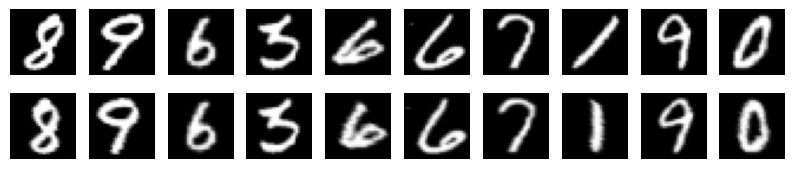

Imagenes de entrenamiento despues de endezar.


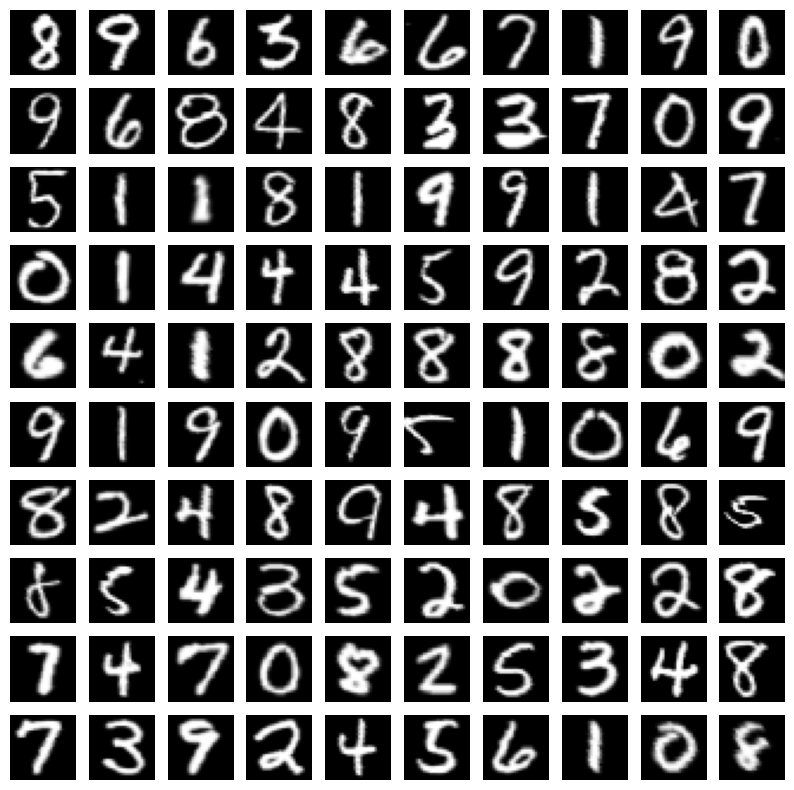

In [76]:
def deskew(image):
    image = image.reshape(28, 28)
    
    m = cv2.moments(image)
    
    if abs(m["mu02"]) < 1e-2:
        # no deskewing needed.
        return image
    
    # calculate skew based on central moments
    skew = m["mu11"] / m["mu02"]
    
    # calculate affine transform to correct skewness
    M = np.float32([[1, skew, -0.5 * 28 * skew], [0, 1, 0]])
    
    # apply affine transform
    image = cv2.warpAffine(
        image, M, (28, 28), flags=cv2.WARP_INVERSE_MAP | cv2.INTER_LINEAR
    )
    
    return image


print("Algunas imagenes de entrenamiento antes y despues de endezar.")
# plot some deskewed images and compare them to the original ones
fig, ax = plt.subplots(2, 10, figsize=(10, 2))
for i in range(10):
    ax[0, i].imshow(images_train[i], cmap="gray")
    ax[0, i].axis("off")
    ax[1, i].imshow(deskew(images_train[i]), cmap="gray")
    ax[1, i].axis("off")
plt.show()

images_train = np.apply_along_axis(deskew, 1, images_train.reshape(-1, 784))
images_test = np.apply_along_axis(deskew, 1, images_test.reshape(-1, 784))

print("Imagenes de entrenamiento despues de endezar.")
# plot some training images
fig, ax = plt.subplots(10, 10, figsize=(10, 10))
for i in range(10):
    for j in range(10):
        ax[i, j].imshow(images_train[i * 10 + j], cmap="gray")
        ax[i, j].axis("off")
plt.show()


## Analisis Exploratorio de Datos

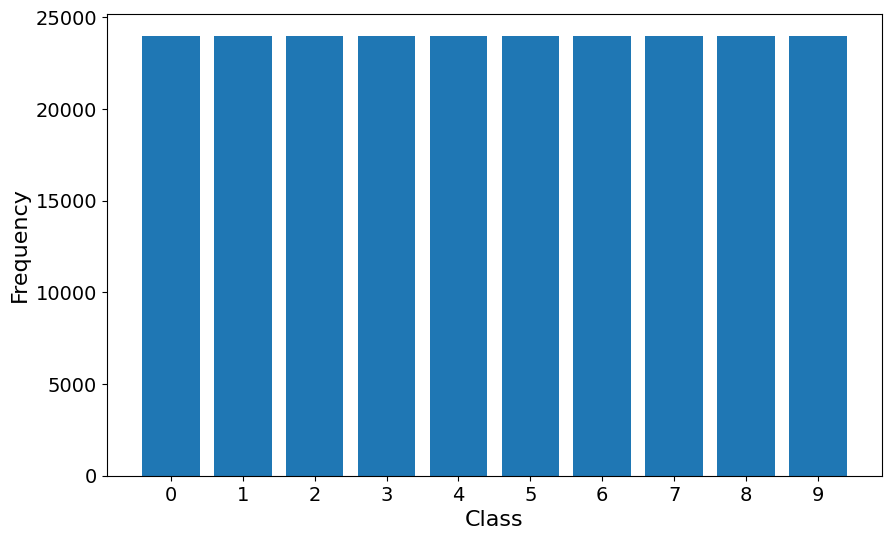

In [77]:
# plot distribution of labels
plt.figure(figsize=(10, 6))
plt.bar(np.arange(10), np.sum(labels_train, axis=0))
plt.xticks(np.arange(10), fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Class", fontsize=16)
plt.ylabel("Frequency", fontsize=16)
plt.show()


## Modelamiento

### Clasificador Lineal

Clasificamos los digitos mediante la norma contra los valores promedios por pixel de las imagenes de entrenamiento. La norma mas pequeña se interpreta como la menor desviacion del digito "identificador".

In [78]:
# create a variable for each training number
train0 = images_train[labels_train[:, 0] == 1]
train1 = images_train[labels_train[:, 1] == 1]
train2 = images_train[labels_train[:, 2] == 1]
train3 = images_train[labels_train[:, 3] == 1]
train4 = images_train[labels_train[:, 4] == 1]
train5 = images_train[labels_train[:, 5] == 1]
train6 = images_train[labels_train[:, 6] == 1]
train7 = images_train[labels_train[:, 7] == 1]
train8 = images_train[labels_train[:, 8] == 1]
train9 = images_train[labels_train[:, 9] == 1]


In [79]:
# print the shape of each training variable in a loop
for i in range(10):
    print(f"{i}: {eval(f'train{i}').shape}")


0: (24000, 28, 28)
1: (24000, 28, 28)
2: (24000, 28, 28)
3: (24000, 28, 28)
4: (24000, 28, 28)
5: (24000, 28, 28)
6: (24000, 28, 28)
7: (24000, 28, 28)
8: (24000, 28, 28)
9: (24000, 28, 28)


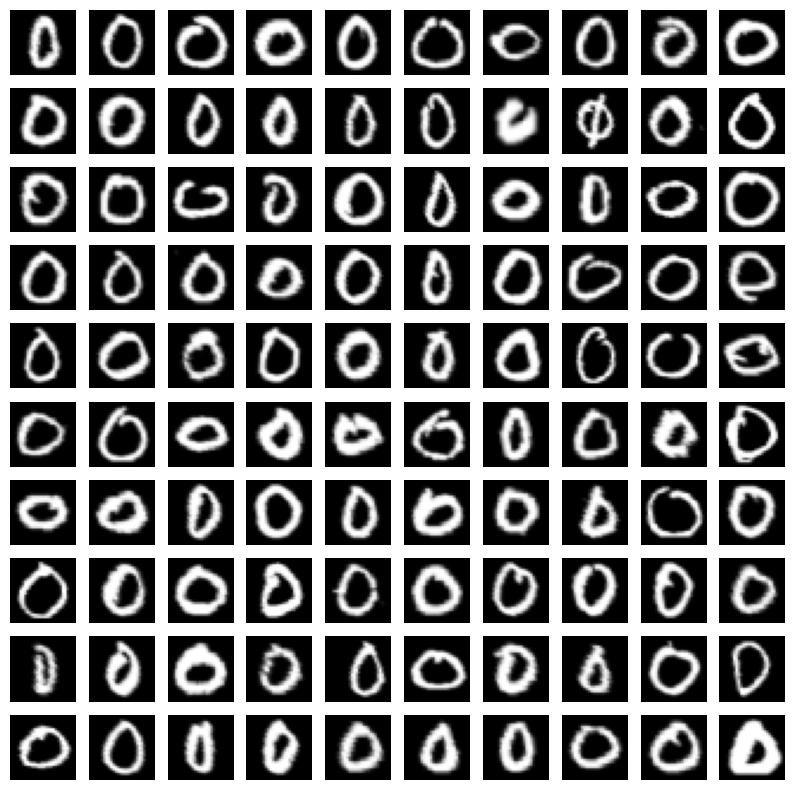

In [80]:
# plot some training images labeled zero
fig, ax = plt.subplots(10, 10, figsize=(10, 10))
for i in range(10):
    for j in range(10):
        ax[i, j].imshow(train0[i * 10 + j].reshape(28, 28), cmap="gray")
        ax[i, j].axis("off")
plt.show()


In [81]:
# create a vector of the mean of each training number
means_train = []
for i in range(10):
    means_train.append(np.mean(eval(f"train{i}"), axis=0))
means_train = np.array(means_train)
means_train.shape


(10, 28, 28)

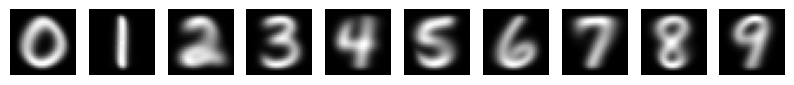

In [82]:
# average the training images of each number and plot them
fig, ax = plt.subplots(1, 10, figsize=(10, 10))
for i in range(10):
    ax[i].imshow(means_train[i].reshape(28, 28), cmap="gray")
    ax[i].axis("off")
plt.show()


In [83]:
# calculate the precision of the mean images by choosing the minimum norm between the mean images and the test images
norms = np.linalg.norm(images_test.reshape(-1, 784, 1) - means_train.reshape(1, 784, 10), axis=1)
predictions = np.argmin(norms, axis=1)
precision = predictions/labels_test.argmax(axis=1)

print(
    f"Precisión de la clasificación: {np.round(np.mean(precision == 1) * 100, 2)}%"
)

Precisión de la clasificación: 6.93%


/tmp/ipykernel_333/2304513003.py:4: RuntimeWarning: divide by zero encountered in divide
  precision = predictions/labels_test.argmax(axis=1)
/tmp/ipykernel_333/2304513003.py:4: RuntimeWarning: invalid value encountered in divide
  precision = predictions/labels_test.argmax(axis=1)


### Arbol de Decision

Implementamos un arbol de decision mediante sklearn. Entrenamos un solo árbol de decisión en todas las características de píxeles y verificamos qué puntuación obtenemos.

In [84]:
# parameters
n_classes = 10
plot_colors = "ryb"
plot_step = 0.02

# define the classifier
clf = DecisionTreeClassifier()

# train the model
clf.fit(images_train.reshape(-1, 784), np.argmax(labels_train, axis=1))

print(f"Profundidad del árbol: {clf.get_depth()}")
print(
    f"Precisión de la clasificación: {np.round(clf.score(images_test.reshape(-1, 784), np.argmax(labels_test, axis=1)),3)}"
)


Profundidad del árbol: 67
Precisión de la clasificación: 0.937


### Red Neuronal (Extra)

Implementamos una red neuronal prealimentada desde cero. Se tienen 20 neuronas en la capa de entrada, 1 capa escondida y 10 neuronas en la capa de salida (las cuales representan las etiquetas).
Usamos la funcion sigmoide como funcion de activacion.


In [85]:
# 20 input neurons, 10 output neurons
weight_i_h = np.random.uniform(-0.5, 0.5, (20, 784))
weight_h_o = np.random.uniform(-0.5, 0.5, (10, 20))
bias_i_h = np.zeros((20, 1))
bias_h_o = np.zeros((10, 1))

In [86]:
# parameters
learn_rate = 0.1
epochs = 3

for epoch in tqdm.tqdm(range(epochs)):
    nr_correct = 0
    for image, layer in zip(images_train, labels_train):
        image = image.reshape(784, 1)
        layer = layer.reshape(-1, 1)

        # forward propagation: input layer to hidden layer
        h_pre = bias_i_h + weight_i_h @ image
        h = 1 / (1 + np.exp(-h_pre))

        # forward propagation: hidden layer to output layer
        o_pre = bias_h_o + weight_h_o @ h
        o = 1 / (1 + np.exp(-o_pre))

        # error function (mse)
        e = np.sum((o - layer) ** 2, axis=0) / len(o)
        nr_correct += int(np.argmax(o) == np.argmax(layer))

        # backpropagation: output layer to hidden layer
        delta_o = o - layer
        weight_h_o -= learn_rate * delta_o @ h.T
        bias_h_o -= learn_rate * delta_o

        # backpropagation: hidden layer to input layer
        delta_h = weight_h_o.T @ delta_o * h * (1 - h)
        weight_i_h -= learn_rate * delta_h @ image.T
        bias_i_h -= learn_rate * delta_h
    print(
        f"Epoch {epoch + 1} completa. Error: {e}, Precision: {nr_correct / len(labels_train)}"
    )


 33%|███▎      | 1/3 [00:26<00:52, 26.11s/it]

Epoch 1 completa. Error: [1.04409702e-05], Precision: 0.9367291666666666


 67%|██████▋   | 2/3 [00:49<00:24, 24.40s/it]

Epoch 2 completa. Error: [2.80863587e-06], Precision: 0.9515166666666667


100%|██████████| 3/3 [01:12<00:00, 24.10s/it]

Epoch 3 completa. Error: [2.55693759e-06], Precision: 0.9542041666666666


## Predicción

In [87]:
# define a prediction function, with the method as an argument. use match statement
def predict(image, method):
    if method == "linearclassifier":
        norms = []
        for j in range(10):
            norms.append(np.linalg.norm(means_train[j] - image))

        return np.argmin(np.array(norms))

    elif method == "decisiontree":
        return clf.predict(image.reshape(1, -1))[0]

    elif method == "neuralnetwork":
        image = image.reshape(784, 1)

        # forward propagation: input layer to hidden layer
        h_pre = bias_i_h + weight_i_h @ image
        h = 1 / (1 + np.exp(-h_pre))

        # forward propagation: hidden layer to output layer
        o_pre = bias_h_o + weight_h_o @ h
        o = 1 / (1 + np.exp(-o_pre))

        return np.argmax(o)


Imagen número 19866
Predicción usando Clasificador Lineal: 7
Predicción usando Árbol de Decisión: 7
Predicción usando Red Neuronal: 7
Valor real: 7


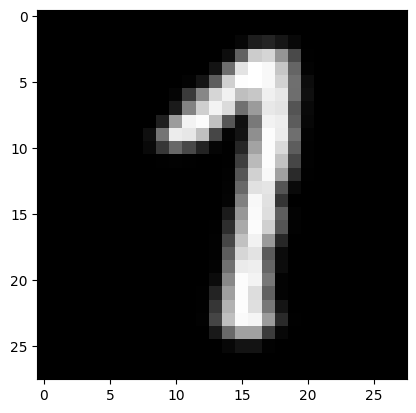

In [160]:
method_dict = {"linearclassifier": "Clasificador Lineal", "decisiontree": "Árbol de Decisión", "neuralnetwork": "Red Neuronal"}
# predict a random image and plot it with the prediction
random_index = np.random.randint(0, len(images_test))
random_image = images_test[random_index]
plt.imshow(random_image, cmap="gray")
print("Imagen número", random_index)
for method in method_dict.keys():
    print(f"Predicción usando {method_dict[method]}: {predict(random_image, method)}")
print("Valor real:", np.argmax(labels_test[random_index]))

In [89]:
# get images that are misclassified by all methods
misclassified = []
for i, image in enumerate(images_test):
    if (
        predict(image, "linearclassifier") != np.argmax(labels_test[i])
        and predict(image, "decisiontree") != np.argmax(labels_test[i])
        and predict(image, "neuralnetwork") != np.argmax(labels_test[i])
    ):
        misclassified.append(i)
print("Número de imágenes mal clasificadas por todos los métodos:", len(misclassified))

Número de imágenes mal clasificadas por todos los métodos: 613


---

Imagen número 1313
Predicción usando Clasificador Lineal: 1
Predicción usando Árbol de Decisión: 1
Predicción usando Red Neuronal: 6
Valor real: 1


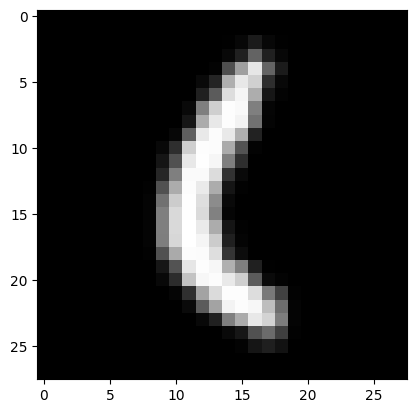

In [90]:
# ask the user for an image index and plot it with the predictions
index = int(input("Introduce un índice de imagen: "))
image = images_test[index]
plt.imshow(image, cmap="gray")
print("Imagen número", index)
for method in method_dict.keys():
    print(f"Predicción usando {method_dict[method]}: {predict(image, method)}")
print("Valor real:", np.argmax(labels_test[index]))

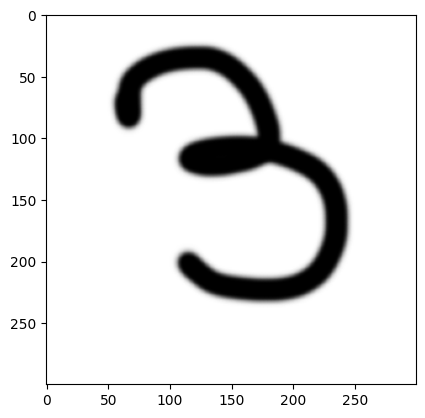

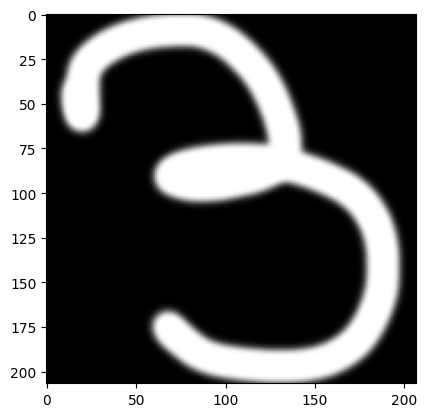

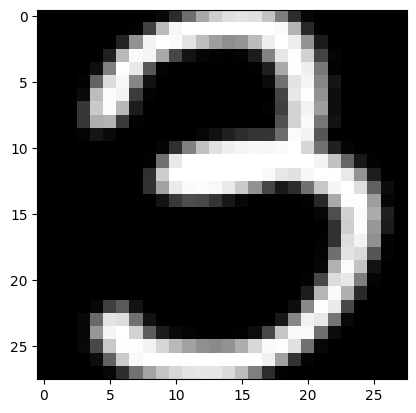

Predicción usando Clasificador Lineal: 9
Predicción usando Árbol de Decisión: 7
Predicción usando Red Neuronal: 3


In [129]:
# ask the user to input a filename in the folder "input" for a custom image and plot it with the predictions
filename = input("Introduce el nombre de un archivo de imagen:")
file_image = plt.imread("input/" + filename)

plt.imshow(file_image, cmap="gray")
plt.show()

# invert the colors of the image
file_image = 1 - file_image

# convert the image to grayscale
file_image = cv2.cvtColor(file_image, cv2.COLOR_BGR2GRAY)

# set values above 0.5 to 1, and below to 0, convert the image to uint8
contour_image = file_image
contour_image = (file_image > 0.5).astype(np.uint8)

# get contours
contours = cv2.findContours(contour_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = contours[0] if len(contours) == 2 else contours[1]
big_contour = max(contours, key=cv2.contourArea)

# get bounding box
x, y, w, h = cv2.boundingRect(big_contour)
if w > h:
    y -= int((w - h) / 2)
    h = w
else:
    x -= int((h - w) / 2)
    w = h

cropped_image = file_image[y : y + h, x : x + w]

plt.imshow(cropped_image, cmap="gray")
plt.show()

# resize the image to 28x28
cropped_image = cv2.resize(cropped_image, (28, 28), interpolation=cv2.INTER_AREA)
# deskew the image
cropped_image = deskew(cropped_image)

plt.imshow(cropped_image, cmap="gray")
plt.show()
for method in method_dict.keys():
    print(f"Predicción usando {method_dict[method]}: {predict(cropped_image, method)}")
